In [1]:
import sys
import time
import random
import csv
import numpy as np

import scipy.io
from scipy.io import loadmat

import torch
import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils

import copy
# Enable autoreload
%load_ext autoreload
%autoreload 2
importlib.reload(utils)

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_dtype(TORCH_DTYPE)
torch.set_default_device(device)
print(f'Device is: {device}')

torch.set_grad_enabled(False)



Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)
Device is: cuda:0


### How this works:

We choose initial training points to be considered a random set of images to present to the retina. On this set, the complete GP will be run , to find STA paramaters eps_0: center, beta: width , rho: smoothness

We run the algorithm saving the seed used for picking the training images, so that this set can be changed and different runs with different initial conditions can be averaged.

1. Import the dataset and create a total training set X,R
2. Pick the cell and the initial training points, extracted randomly. These correspond also to the number of inducing points
3. Save the seed so you can keep the initial training set, and the fitted model
3. 


### Parameters of the training

In [2]:
rand_xtilde = True # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images

cellid       = 8         # Choose cell
ntrain_start = 50        # Number of first training data points

kernfun      = 'acosker' # Choose kernel function

nEstep       = 10         # Total number of E-steps iterations.
nFparamstep  = 10  
nMstep       = 10         # Total number of M-steps iterations. 
maxiter      = 10         # Iterations of the optimization algorithm comprising M and E steps

ntilde       = ntrain_start

### Import dataset and generate starting dataset

Create starting dataset on which to train with m step with ntilde = ntrain_start

In [3]:
# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training points
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Create the complete dataset
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)

n_px_side = X.shape[1]  

# Reshape images to 1D vector and choose a cell
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
R = R[:,cellid] # shape (nt,) where nt is the number of trials

# Choose a random subset of the data and save the idx
all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
torch.manual_seed(0)
torch.cuda.manual_seed(0)
all_idx_perm  = torch.randperm(all_idx.shape[0])                         # Random permutation of the indices

test_1000_idx = all_idx_perm[-1000:]                                     # These will be the indices of the test set
all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_1000_idx )] # Remove the test set indices from the permutation
rndm_idx      = all_idx_perm[:ntrain_start]                              # These will be the indices of the initial training. This way ensures not repetitions.


start_idx     = rndm_idx
# start_idx     = rndm_idx.sort()[0]
in_use_idx    = start_idx
xtilde_idx    = in_use_idx
remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]
# remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

# Set the starting set
xtilde_start  = X[xtilde_idx,:]                           # In the simplest case the starting points are all inducing points
X_in_use      = X[in_use_idx,:]
X_remaining   = X[remaining_idx,:]
X_test_1000   = X[test_1000_idx,:]

R_remaining   = R[remaining_idx]
R_in_use      = R[in_use_idx]
R_test_1000   = R[test_1000_idx]

# Estimate memory usage
# Calculate memory usage for each tensor
X_memory = X.element_size() * X.nelement()
r_memory = R.element_size() * R.nelement()
# Total memory usage in bytes
total_memory_bytes = X_memory + r_memory
# Convert bytes to megabytes (MB)
total_memory_MB = total_memory_bytes / (1024 ** 2)
print(f'Total dataset memory on GPU: {total_memory_MB:.2f} MB')


Total dataset memory on GPU: 281.23 MB


### Select cell, starting hyperparameters and firing rate parameters

In [4]:
torch.set_grad_enabled(False)
# For details on the hyperparameters choice see one_cell_fit.ipynb
logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 
# logbetaexpr = torch.tensor(4.65)
# logrhoexpr = torch.tensor(4.3)
sigma_0    = torch.tensor(1.0)
Amp        = torch.tensor(1.0) 
eps_0x     = torch.tensor(0.0001)
eps_0y     = torch.tensor(0.0001)
# Hypermarameters, if needed to be set manually
theta = {'sigma_0': sigma_0, 'Amp': Amp, 'eps_0x':eps_0x, 'eps_0y':eps_0y, '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr,  }

# Set the gradient of the hyperparemters to be updatable 
for key, value in theta.items(): # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nmstep=0 and dont do the M-step)
    # if key == 'Amp':
        # continue
    theta[key] = value.requires_grad_()

# If hyperparameters are set manually:
# theta = prev_theta
hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True, **theta)
# If hyperparameters are set based on the STAs:
# hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)

A        = torch.tensor(0.01)
logA     = torch.log(A)
# lambda0  = torch.tensor(0.31)
lambda0  = torch.tensor(1.)
f_params = {'logA': logA, 'lambda0':lambda0}
f_params['logA'] = f_params['logA'].requires_grad_() # The optimal lambda0 is given with a fixed A.

fit_parameters = {'ntilde':      ntilde,
                  'maxiter':     maxiter,
                  'nMstep':      nMstep,
                  'nEstep':      nEstep,
                  'nFparamstep': nFparamstep,
                  'kernfun':     kernfun,
                  'cellid':      cellid,
                  'n_px_side':   n_px_side,
                  'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                  'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                  'start_idx':   start_idx }     # Indexes used to generate the initial training set, same as the starting xtilde

init_model = {
        'fit_parameters':    fit_parameters,
        'xtilde':            xtilde_start,
        'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
        'f_params':          f_params,
        # 'm':                 torch.zeros( (ntilde) )
        # 'm': torch.ones( (ntilde) )
        #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
    }

updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to 0.0001
updated eps_0y to 0.0001
updated -2log2beta to 4.8069
updated -log2rho2 to 4.3069


### Fit the starting model
And save it needed to start a new active fit

Total values_track memory on GPU: 0.00 MB

After initialization Allocated memory: 864.32 MB

After initialization Reserved (cached) memory: 884.00 MB
Initial Loss: 112.0424
Loss iter 1: 66.9005
Loss iter 2: 66.8968
Loss iter 3: 66.8964
Loss iter 4: 66.8961
Loss iter 5: 66.8958
Loss iter 6: 66.8956
Loss iter 7: 66.8953
Loss iter 8: 66.8950
Loss iter 9: 66.8947

Time spent for E-steps:       0.744s,
Time spent for f params:      0.546s
Time spent computing Lambda0: 0.009s
Time spent for m update:      0.198s
Time spent for M-steps:       0.485s
Time spent for All-steps:     1.229s
Time spent computing Kernels: 0.017s
Time spent computing Loss:    0.005s

Time total after init:        1.257s
Time total before init:       1.313s
Final Loss: 66.8947


 Pietro's model: R2 = 0.31 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



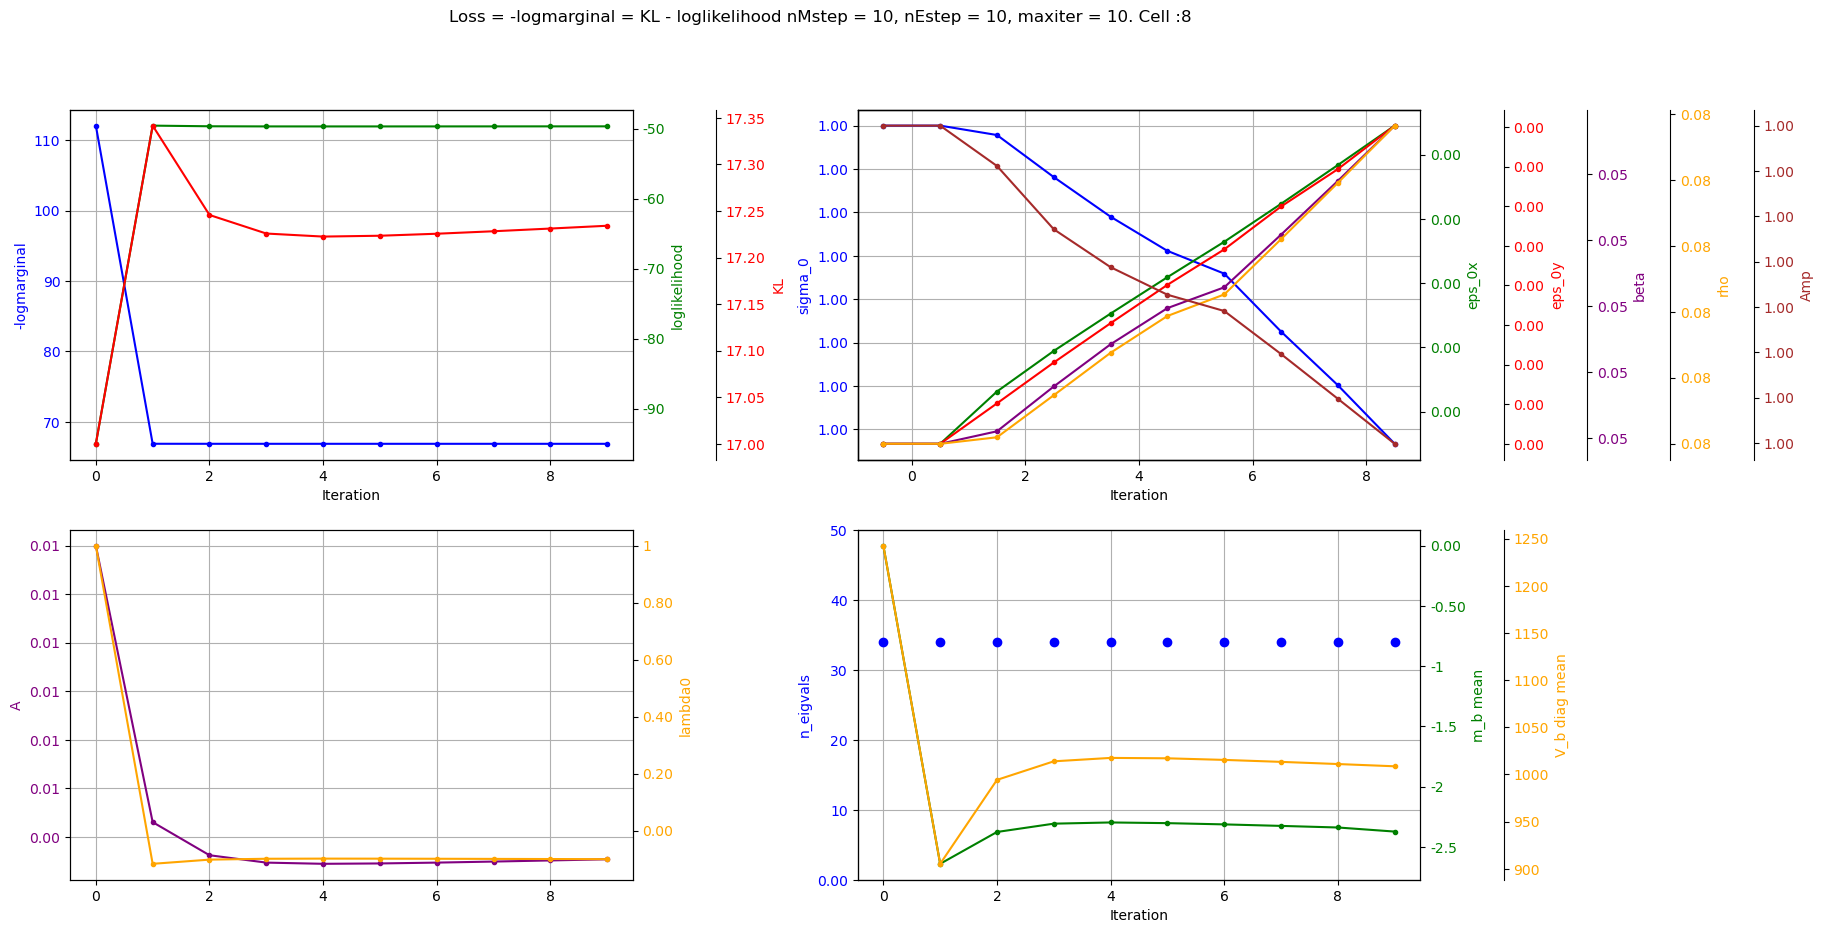

In [5]:
torch.set_grad_enabled(False)
fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

# Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
start_model = fit_model

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

# Save the model
# utils.save_model(start_model, f'models/starting_models_active_learning/cell:{cellid}_nstart:{ntrain_start}', additional_description='Starting model for active learning')

spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **fit_model )
# spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **start_model )

utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))


### Save or load model

In [6]:
# Save the model
# utils.save_model(fit_model, f'models/bugs/cell:{cellid}', additional_description='Model started with 50 ntilde=ntrain, randomly picked images until nan in r2. Saved last model (after fit ). It gives Nan')
# start_model = utils.load_model(f'models/starting_models_active_learning/cell:8_nstart:20')

### Evaluate the utility of each remaining image
New version

In [7]:
in_use_idx    = start_model['fit_parameters']['in_use_idx']
xtilde_idx    = start_model['fit_parameters']['xtilde_idx']

remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

X_remaining = X[remaining_idx]
R_remaining = R[remaining_idx]

xtilde      = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

xstar = X_remaining

kernfun       = start_model['fit_parameters']['kernfun']
mask          = start_model['mask']
C             = start_model['C']
B             = start_model['B']
K_tilde_b     = start_model['K_tilde_b']
K_tilde_inv_b = start_model['K_tilde_inv_b']
K_b           = start_model['K_b']
Kvec          = start_model['Kvec']
m_b           = start_model['m_b']
V_b           = start_model['V_b']    
f_params_fit  = start_model['f_params']
A             = torch.exp(f_params_fit['logA'])
lambda0       = torch.exp(f_params_fit['loglambda0']) if 'loglambda0' in f_params_fit else f_params_fit['lambda0']

start_time = time.time()

# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  

logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t

# Estimate the utility and cap the maximum r ( used in a summation to infinity )
r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
u2d = utils.nd_utility(logf_var, logf_mean, r_masked )
print(f'\nElapsed time for lambda moments and utility : {time.time()-start_time:.2f} seconds')  



Elapsed time for lambda moments and utility : 0.02 seconds


### Find the index(es) for the most useful image 
Check the correspondence between the index: ```i_best``` of the ```xstar = X_remaining``` images with the one: ```x_idx_best```  for the complete dataset ```X```

In [8]:
i_best     = u2d.argmax()           # Index of the best image in the utility vector
x_idx_best = remaining_idx[i_best]  # Index of the best image in the dataset indices
print(f'Utility: {u2d[i_best].item():<8.4f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')


# Using the indexes of the utility
Kvec = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var[i_best], logf_mean[i_best], r_masked)} and f_mean :{torch.exp(logf_mean[i_best]).item():8.4f}')


# Using the indixes of the dataset X
# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 
lambda_m_t, lambda_var_t = utils.lambda_moments( X[x_idx_best,mask][None,:], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var, logf_mean, r_masked)} and f_mean :{torch.exp(logf_mean).item():8.4f}')

Utility: 0.0746   |  Best image ID: 1875  | Best image index: 3072
 this has utility tensor([0.0746], device='cuda:0') and f_mean :  0.9790
 this has utility tensor([0.0746], device='cuda:0') and f_mean :  0.9790


### Update the indexes tensors and fit the new model

After fitting the model with the dataset incremented by one image, reevaluate the utility, find the best mage index and loop.

In the same loop, also extract random image indexes for training a parallel model.

In [9]:
torch.set_grad_enabled(False)

active_model = copy.deepcopy(start_model)
# random_model = copy.deepcopy(start_model)
# fit_model = copy.deepcopy(prev_model)

r2_vec = []
r2_vec2 = []
r2_vec_benchmark = []
loss_vec = []
loss_vec2 = []
loss_vec_benchmark = []

for j in range(100):
    print(f'=========== New image number {j} ====================')

    # region ________ Active model __________
    in_use_idx    = active_model['fit_parameters']['in_use_idx']
    xtilde_idx    = active_model['fit_parameters']['xtilde_idx']

    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]

    xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

    xstar  = X_remaining

    kernfun       = active_model['fit_parameters']['kernfun']
    if kernfun == 'acosker': kernfun = utils.acosker
    n_px_side     = active_model['fit_parameters']['n_px_side']
    EIGVAL_TOL    = active_model['fit_parameters']['eigval_tol']

    final_kernel  = active_model['final_kernel']
    
    mask          = active_model['mask']
    C             = active_model['C']
    B             = active_model['B']
    K_tilde_b     = active_model['K_tilde_b']
    K_tilde_inv_b = active_model['K_tilde_inv_b']
    K_b           = active_model['K_b']
    Kvec          = active_model['Kvec']
    m_b           = active_model['m_b']
    V_b           = active_model['V_b']    
    f_params      = active_model['f_params']
    theta         = active_model['hyperparams_tuple'][0]
    A             = torch.exp(f_params['logA'])
    lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']
    
    theta_lower_lims  = active_model['hyperparams_tuple'][1]
    theta_higher_lims = active_model['hyperparams_tuple'][2]


    # Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
    Kvec_star = kernfun(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
    K_star    = kernfun(theta, xstar[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
    K_star_b  = K_star @ B 

    lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star_b@K_tilde_inv_b, Kvec_star, K_star_b, C, m_b, V_b, theta, kernfun)  

    logf_mean = A*lambda_m_t + lambda0
    logf_var  = A**2 * lambda_var_t

    # Estimate the utility and cap the maximum r ( used in a summation to infinity )
    r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
    u2d      = utils.nd_utility(logf_var, logf_mean, r_masked )

    i_best   = u2d.argmax()                 # Index of the best image in the utility vector
    x_idx_best   = remaining_idx[i_best]    # Index of the best image in the dataset indices
    print(f'Utility: {u2d[i_best].item():<8.6f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')

    if x_idx_best in in_use_idx :
        raise ValueError('The best image is already in use or in the test set')
    if x_idx_best in test_1000_idx:
        raise ValueError('The best image is in the test set')
      

    # __________ Update indices. 
    # Always sort the indices. We also update the remaining only to have consistency, not cause they are used here
    in_use_idx    = torch.cat( (in_use_idx, x_idx_best[None]))
    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

    X_in_use    = X[in_use_idx]
    R_in_use    = R[in_use_idx] 
    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]
    # # The added images are used as inducing points as long as the number of inducing points is less than 200
    # # if in_use_idx.shape[0] < 200:
    xtilde_idx     = in_use_idx
    ntilde         = xtilde_idx.shape[0]
    nt             = X_in_use.shape[0]
    # We add it as the last row. This is not ensured if we use X[xtilde_idx] instead of xtilde
    xtilde_updated = X[xtilde_idx]
    # xtilde_updated = torch.cat((xtilde, X[x_idx_best][None,:]), axis=0) 

    active_model['xtilde']                       = xtilde_updated
    active_model['fit_parameters']['ntilde']     = ntilde
    active_model['fit_parameters']['in_use_idx'] = in_use_idx
    active_model['fit_parameters']['xtilde_idx'] = xtilde_idx

    # __________ Update variational parameters
    # To update the variational parameters to the new dimensionality we need to pass through the original space. 
    # V and m will be projected onto the right eigenspace in varGP using the last used B.
    V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
    V = 0.5*(V + V.T)    # Ensure symmetry
    m = B @ m_b          # shape (ntilde-1,)

    V_new = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)#*lambda_var_t[i_best]
    V_new[:ntilde-1, :ntilde-1] = V       

    active_model['V'] = V_new 
    active_model['m'] = torch.cat( (m, m.mean()[None]))

    # __________ Update kernel matrices by only computing their latest column
    init_kernel = {}
    C                     = final_kernel['C']
    mask                  = final_kernel['mask']
    K_tilde_reduced       = final_kernel['K_tilde']            # We call it reduced because its still the Ktilde used in the last iteration
    K_reduced             = final_kernel['K']           
    P                     = final_kernel['eigvecs']            # Projection matrix to the complete eigenspace

    #100 computattions of K_tilde this way take ~0.03s.
    K_tilde_column  = kernfun(theta, xtilde_updated[:,mask], xtilde_updated[-1,mask][None], C=C, dC=None, diag=False) 
    K_tilde         = torch.cat((K_tilde_reduced, K_tilde_column[:-1]), axis=1)
    K_tilde         = torch.cat((K_tilde, K_tilde_column.T), axis=0)  

    if ntilde==nt: K = K_tilde
    else: raise NotImplementedError('Fast calculation of K not implemented for ntilde != ntrain')

    Kvec            = kernfun(theta, X_in_use[:,mask],x2=None, C=C, dC=None, diag=True)   

    eigvals, eigvecs = torch.linalg.eigh(K_tilde, UPLO='L')                                # calculates the eigenvals for an assumed symmetric matrix, eigenvalues  are returned in ascending order. Uplo=L uses the lower triangular part of the matrix. Eigenvectors are columns
    ikeep            = eigvals > max(eigvals.max() * EIGVAL_TOL, EIGVAL_TOL)                          # Keep only the largest eigenvectors
    B                = eigvecs[:, ikeep]                                     
    # make K_tilde_b and K_b a projection of K_tilde and K into the eigenspace of the largest eigenvectors
    K_tilde_b        = torch.diag(eigvals[ikeep])                    
    K_b              = K @ B                                         
    
    K_tilde_inv_b = torch.diag_embed(1/eigvals[ikeep])        
    KKtilde_inv_b = B if ntilde==nt else K_b @ K_tilde_inv_b

    init_kernel['C']                 = C
    init_kernel['mask']              = mask
    init_kernel['K_tilde']           = K_tilde
    init_kernel['K']                 = K
    init_kernel['Kvec']              = Kvec
    init_kernel['B']                 = B
    init_kernel['K_tilde_b']         = K_tilde_b
    init_kernel['K_b']               = K_b
    init_kernel['K_tilde_inv_b']     = K_tilde_inv_b
    init_kernel['KKtilde_inv_b']     = KKtilde_inv_b

    print(f'Number of inducing points: {ntilde}')
    print(f'Number of images used:     {in_use_idx.shape[0]}')

    # __________ Save previous model and fit the new one.
    active_model['init_kernel']      = init_kernel        # We update the model after copy because deepcopy doesnt work if 'init_kernel' is a key
    prev_active_model = copy.deepcopy(active_model)

    active_model, err_dict = utils.varGP(X_in_use, R_in_use, **active_model)

    if err_dict['is_error']:
        print('Error in the fit')
        raise err_dict['error']

    spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **active_model )

    if torch.any(torch.isnan(r2)):
        print('r2 is nan')
        raise ValueError('r2 is nan')

    r2_vec.append(r2)
    loss_vec.append(-active_model['values_track']['loss_track']['logmarginal'][-1])

utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))

=========== New image number 0 ====================
Utility: 0.074604 |  Best image ID: 1875  | Best image index: 3072
Number of inducing points: 51
Number of images used:     51
Total values_track memory on GPU: 0.00 MB

After initialization Allocated memory: 1072.93 MB

After initialization Reserved (cached) memory: 1100.00 MB
Initial Loss: 276.8390
Loss iter 1: 67.3418
Loss iter 2: 67.3397
Loss iter 3: 67.3392
Loss iter 4: 67.3390
Loss iter 5: 67.3389
Loss iter 6: 67.3389
Loss iter 7: 67.3389
Loss iter 8: 67.3389
Loss iter 9: 67.3389

Time spent for E-steps:       0.451s,
Time spent for f params:      0.404s
Time spent computing Lambda0: 0.010s
Time spent for m update:      0.047s
Time spent for M-steps:       0.232s
Time spent for All-steps:     0.683s
Time spent computing Kernels: 0.020s
Time spent computing Loss:    0.004s

Time total after init:        0.710s
Time total before init:       0.714s
Final Loss: 67.3389


 Pietro's model: R2 = 0.39 ± 0.01 Cell: 8 maxiter = 10, nEstep

KeyboardInterrupt: 

In [ ]:
torch.set_grad_enabled(False)

active_model = copy.deepcopy(start_model)
random_model = copy.deepcopy(start_model)
# fit_model = copy.deepcopy(prev_model)

r2_vec = []
r2_vec2 = []
r2_vec_benchmark = []
loss_vec = []
loss_vec2 = []
loss_vec_benchmark = []

for j in range(200):
    print(f'=========== New image number {j} ====================')

    # region ________ Active model __________
    in_use_idx    = active_model['fit_parameters']['in_use_idx']
    xtilde_idx    = active_model['fit_parameters']['xtilde_idx']

    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]

    xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

    xstar  = X_remaining

    kernfun       = active_model['fit_parameters']['kernfun']
    if kernfun == 'acosker': kernfun = utils.acosker
    n_px_side     = active_model['fit_parameters']['n_px_side']
    EIGVAL_TOL    = active_model['fit_parameters']['eigval_tol']
    
    mask          = active_model['mask']
    C             = active_model['C']
    B             = active_model['B']
    K_tilde_b     = active_model['K_tilde_b']
    K_tilde_inv_b = active_model['K_tilde_inv_b']
    K_b           = active_model['K_b']
    Kvec          = active_model['Kvec']
    m_b           = active_model['m_b']
    V_b           = active_model['V_b']    
    f_params      = active_model['f_params']
    theta         = active_model['hyperparams_tuple'][0]
    A             = torch.exp(f_params['logA'])
    lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']
    
    theta_lower_lims  = active_model['hyperparams_tuple'][1]
    theta_higher_lims = active_model['hyperparams_tuple'][2]


    # Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
    Kvec_star = kernfun(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
    K_star    = kernfun(theta, xstar[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
    K_star_b  = K_star @ B 

    lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star_b@K_tilde_inv_b, Kvec_star, K_star_b, C, m_b, V_b, theta, kernfun)  

    logf_mean = A*lambda_m_t + lambda0
    logf_var  = A**2 * lambda_var_t

    # Estimate the utility and cap the maximum r ( used in a summation to infinity )
    r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
    u2d      = utils.nd_utility(logf_var, logf_mean, r_masked )

    i_best   = u2d.argmax()                 # Index of the best image in the utility vector
    x_idx_best   = remaining_idx[i_best]    # Index of the best image in the dataset indices
    print(f'Utility: {u2d[i_best].item():<8.6f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')

    if x_idx_best in in_use_idx :
        raise ValueError('The best image is already in use or in the test set')
    if x_idx_best in test_1000_idx:
        raise ValueError('The best image is in the test set')
      
    # region Check that the indexes correspond.

    # # Using the indexes of the utility
    # Kvec_star1 = kernfun(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
    # K_star1    = kernfun(theta, xstar[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
    # K_star1_b  = K_star1 @ B 

    # lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star1_b@K_tilde_inv_b, Kvec_star1, K_star1_b, C, m_b, V_b, theta, kernfun)  
    # logf_mean = A*lambda_m_t + lambda0
    # logf_var  = A**2 * lambda_var_t

    # print(f' this has utility {utils.nd_utility(logf_var[i_best], logf_mean[i_best], r_masked)} and f_mean :{torch.exp(logf_mean[i_best]).item():8.4f} Using indexes of utility')

    # # # Using the indexes of the dataset X
    # # Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
    # Kvec_star2 = kernfun(theta, X[x_idx_best,mask][None,:], x2=None, C=C, dC=None, diag=True)
    # K_star2    = kernfun(theta, X[x_idx_best,mask][None,:], x2=xtilde[:,mask], C=C, dC=None, diag=False)
    # K_star2_b  = K_star2 @ B 
    # lambda_m_t, lambda_var_t = utils.lambda_moments( X[x_idx_best,mask][None,:], K_tilde_b, K_star2_b@K_tilde_inv_b, Kvec_star2, K_star2_b, C, m_b, V_b, theta, kernfun)  
    # logf_mean = A*lambda_m_t + lambda0
    # logf_var  = A**2 * lambda_var_t
    # print(f' this has utility {utils.nd_utility(logf_var, logf_mean, r_masked)} and f_mean :{torch.exp(logf_mean).item():8.4f} Using indexes of dataset X')

    #endregion ################

    # __________ Update indices. 
    # Always sort the indices. We also update the remaining only to have consistency, not cause they are used here

    # Note that unique is still used
    # in_use_idx    = torch.unique(torch.cat( (in_use_idx, x_idx_best[None]))).sort()[0]  
    # remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

    X_in_use    = X[in_use_idx]
    R_in_use    = R[in_use_idx] 
    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]
    # # The added images are used as inducing points as long as the number of inducing points is less than 200
    # # if in_use_idx.shape[0] < 200:
    xtilde_idx     = in_use_idx
    ntilde         = xtilde_idx.shape[0]
    xtilde_updated = X[xtilde_idx]                                          # Same as X_in_use

    active_model['xtilde']                       = xtilde_updated
    active_model['fit_parameters']['ntilde']     = ntilde
    active_model['fit_parameters']['in_use_idx'] = in_use_idx
    active_model['fit_parameters']['xtilde_idx'] = xtilde_idx

    # __________ Update variational parameters
    # To update the variational parameters to the new dimensionality we need to pass through the original space. 
    # V and m will be projected onto the right eigenspace in varGP using the last used B.
    V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
    V = 0.5*(V + V.T)    # Ensure symmetry
    m = B @ m_b          # shape (ntilde-1,)

    V_new   = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)#*lambda_var_t[i_best]
    V_new[:ntilde-1, :ntilde-1] = V       

    active_model['V'] = V_new 
    active_model['m'] = torch.cat( (m, m.mean()[None]))


    # __________ Update kernel matrices 
    init_kernel = {}

    C, mask = utils.localker(theta=theta,  theta_lower_lims=theta_lower_lims, theta_higher_lims=theta_higher_lims, n_px_side=n_px_side, grad=False) 
    K_tilde = kernfun(theta, xtilde_updated[:,mask], xtilde_updated[:,mask], C=C, dC=None, diag=False) 



    K       = kernfun(theta, X_in_use[:,mask],       xtilde_updated[:,mask], C=C, dC=None, diag=False)                                                       
    Kvec    = kernfun(theta, X_in_use[:,mask],       x2=None,                C=C, dC=None, diag=True)                                                        
    
    eigvals, eigvecs = torch.linalg.eigh(K_tilde, UPLO='L')                                # calculates the eigenvals for an assumed symmetric matrix, eigenvalues  are returned in ascending order. Uplo=L uses the lower triangular part of the matrix. Eigenvectors are columns
    ikeep = eigvals > max(eigvals.max() * EIGVAL_TOL, EIGVAL_TOL)                          # Keep only the largest eigenvectors

    B = eigvecs[:, ikeep] + 10                                    # shape (ntilde, n_eigen)            
    # make K_tilde_b and K_b a projection of K_tilde and K into the eigenspace of the largest eigenvectors
    K_tilde_b = torch.diag(eigvals[ikeep])                    # shape (n_eigen, n_eigen)
    K_b       = K @ B                                         # shape (3190, n_eigen)

    K_tilde_inv_b = torch.diag_embed(1/eigvals[ikeep])        # shape (n_eigen, n_eigen)
    KKtilde_inv_b = K_b @ K_tilde_inv_b                       # shape (nt, n_eigen) # this is 'a' in matthews code

    init_kernel['C, mask']           = (C, mask)
    init_kernel['K_tilde']           = K_tilde
    init_kernel['K']                 = K
    init_kernel['Kvec']              = Kvec
    init_kernel['B']                 = B
    init_kernel['K_tilde_b']         = K_tilde_b
    init_kernel['K_b']               = K_b
    init_kernel['K_tilde_inv_b']     = K_tilde_inv_b
    init_kernel['KKtilde_inv_b']     = KKtilde_inv_b


    print(f'Number of inducing points: {ntilde}')
    print(f'Number of images used:     {in_use_idx.shape[0]}')

    # __________ Save previous model and fit the new one.
    active_model['init_kernel']      = init_kernel        # We update the model after copy because deepcopy doesnt work if 'init_kernel' is a key
    prev_active_model = copy.deepcopy(active_model)

    active_model, err_dict = utils.varGP(X_in_use, R_in_use, **active_model)

    if err_dict['is_error']:
        print('Error in the fit')
        raise err_dict['error']

    spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **active_model )

    if torch.any(torch.isnan(r2)):
        print('r2 is nan')
        raise ValueError('r2 is nan')

    r2_vec.append(r2)
    loss_vec.append(-active_model['values_track']['loss_track']['logmarginal'][-1])

    # region _______ Random model __________
    
    # in_use_idx    = random_model['fit_parameters']['in_use_idx']
    # xtilde_idx    = random_model['fit_parameters']['xtilde_idx']

    # remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

    # X_remaining = X[remaining_idx]
    # R_remaining = R[remaining_idx]

    # xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

    # i_random     = torch.randint(0, X_remaining.shape[0], (1,))[0]
    # x_idx_random = remaining_idx[i_random]  # Index of the best image in the dataset indices

    # in_use_idx    = torch.unique(torch.cat( (in_use_idx, x_idx_random[None]))).sort()[0]  
    # remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

    # X_in_use    = X[in_use_idx]
    # R_in_use    = R[in_use_idx] 
    # X_remaining = X[remaining_idx]
    # R_remaining = R[remaining_idx]

    # xtilde_idx     = in_use_idx
    # ntilde         = xtilde_idx.shape[0]
    # xtilde_updated = X[xtilde_idx]                                          # Same as X_in_use

    # B                                            = random_model['B']
    # m_b                                          = random_model['m_b']
    # V_b                                          = random_model['V_b'] 
    # random_model['xtilde']                       = xtilde_updated
    # random_model['fit_parameters']['ntilde']     = ntilde
    # random_model['fit_parameters']['in_use_idx'] = in_use_idx
    # random_model['fit_parameters']['xtilde_idx'] = xtilde_idx

    # V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
    # V = 0.5*(V + V.T)    # Ensure symmetry
    # m = B @ m_b          # shape (ntilde-1,)

    # V_new   = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)
    # V_new[:ntilde-1, :ntilde-1] = V       

    # random_model['V'] = V_new 
    # random_model['m'] = torch.cat( (m, m.mean()[None]))

    # random_model, err_dict = utils.varGP(X_in_use, R_in_use, **random_model)

    # if err_dict['is_error']:
    #     print('Error in the fit')
    #     raise err_dict['error']

    # spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **random_model )

    # r2_vec2.append(r2)
    # loss_vec2.append(-random_model['values_track']['loss_track']['logmarginal'][-1])

    # endregion 

    # region _____________ Benchmark model ____________
    # Benckmarck with a model that has the same inducing points but everything else reset to the initial values
    # benchmark_model = init_model
    # benchmark_model['xtilde']                       = xtilde_updated
    # benchmark_model['fit_parameters']['ntilde']     = ntilde
    # benchmark_model['fit_parameters']['in_use_idx'] = in_use_idx
    # benchmark_model['fit_parameters']['xtilde_idx'] = xtilde_idx

    # prev_benchmark_model = copy.deepcopy(benchmark_model)

    # benchmark_model, err_dict = utils.varGP(X_in_use, R_in_use, **benchmark_model)

    # if err_dict['is_error']:
    #     print('Error in the fit')
    #     print("ERROR IN BENCHMARK")
        
    # spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **benchmark_model )

    # r2_vec_benchmark.append(r2)
    # loss_vec_benchmark.append(-benchmark_model['values_track']['loss_track']['logmarginal'][-1])

    # if torch.any(torch.isnan(r2)):
    #     print('r2 is nan')
    #     raise ValueError('r2 is nan')
    # endregion

# utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))




=========== New image number 0 ====================
Utility: 0.074604 |  Best image ID: 2051  | Best image index: 3072
Number of inducing points: 51
Number of images used:     51


KeyError: 'C'

#### Compare the performance of different sequences images ( random and active )

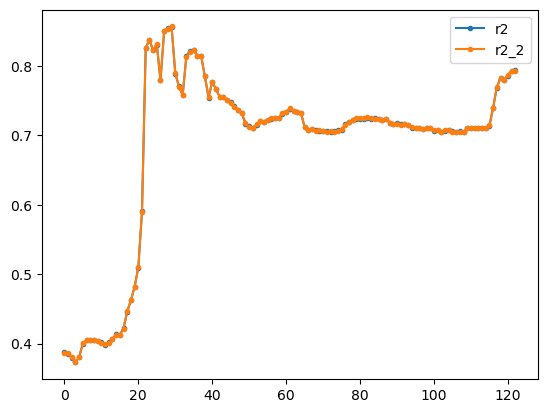

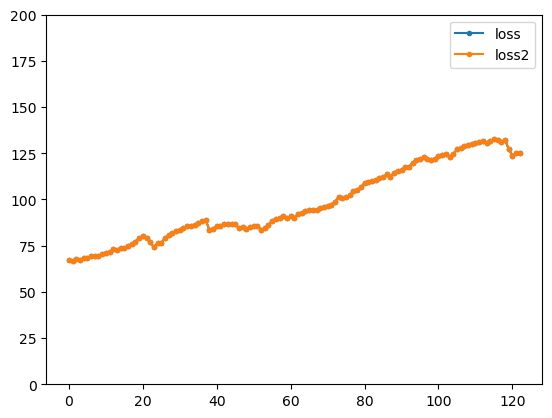

In [ ]:


plt.plot(r2_vec, label='r2', linestyle='-', marker='.')
plt.plot(r2_vec2, label='r2_2', linestyle='-', marker='.')
# plt.plot(r2_vec_benchmark, label='r2 benchmark', linestyle='-', marker='.')
# plt.xlim(20, 30)
plt.legend()
plt.show()

# loss_vec_np = torch.tensor(loss_vec).cpu().numpy()#/torch.arange(50, len(loss_vec)-50)
# loss_vec_benchmark_np = torch.tensor(loss_vec_benchmark).cpu().numpy()#/torch.arange(50, len(loss_vec)-50)

plt.plot(loss_vec, label='loss', linestyle='-', marker='.')
plt.plot(loss_vec2, label='loss2', linestyle='-', marker='.')
# plt.plot(loss_vec_benchmark, label='loss benchmark', linestyle='-', marker='.')
plt.ylim(0, 200)
plt.legend()

### Compare 8 different models ( choosing different starting models each time )

In [ ]:
# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training points
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Create the complete dataset
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)

n_px_side = X.shape[1]  

# Reshape images to 1D vector and choose a cell
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
R = R[:,cellid] # shape (nt,) where nt is the number of trials

active_models_r2 = []
random_models_r2 = []
active_models_loss = []
random_models_loss = []


for i in range(8): # We change the random seed to get different starting points
    # region Initialize starting model

    # Choose a random subset of the data and save the idx
    all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
    torch.manual_seed(i)
    torch.cuda.manual_seed(i)
    all_idx_perm  = torch.randperm(all_idx.shape[0])                         # Random permutation of the indices

    test_1000_idx = all_idx_perm[-1000:]                                     # These will be the indices of the test set
    all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_1000_idx )] # Remove the test set indices from the permutation
    rndm_idx      = all_idx_perm[:ntrain_start]                              # These will be the indices of the initial training. This way ensures not repetitions.


    start_idx     = rndm_idx.sort()[0]
    in_use_idx    = start_idx
    xtilde_idx    = in_use_idx
    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

    # Set the starting set
    xtilde_start  = X[xtilde_idx,:]                           # In the simplest case the starting points are all inducing points
    X_in_use      = X[in_use_idx,:]
    X_remaining   = X[remaining_idx,:]
    X_test_1000   = X[test_1000_idx,:]

    R_remaining   = R[remaining_idx]
    R_in_use      = R[in_use_idx]
    R_test_1000   = R[test_1000_idx]

    # endregion

    # region Initialize hyperparameters
        # For details on the hyperparameters choice see one_cell_fit.ipynb
    logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
    logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 

    sigma_0    = torch.tensor(1.0)
    Amp        = torch.tensor(1.0) 
    eps_0x     = torch.tensor(0.0001)
    eps_0y     = torch.tensor(0.0001)
    # Hypermarameters, if needed to be set manually
    theta = {'sigma_0': sigma_0, 'Amp': Amp, 'eps_0x':eps_0x, 'eps_0y':eps_0y, '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr,  }

    # Set the gradient of the hyperparemters to be updatable 
    for key, value in theta.items():
        # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nmstep=0 and dont do the M-step)
        # if key == 'Amp':
            # continue
        theta[key] = value.requires_grad_()

    # If hyperparameters are set manually:
    # theta = prev_theta
    hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True, **theta)
    # If hyperparameters are set based on the STAs:
    # hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)

    A        = torch.tensor(0.01)
    logA     = torch.log(A)
    # lambda0  = torch.tensor(0.31)
    lambda0  = torch.tensor(1.)
    # f_params = {'logA': logA, 'loglambda0':torch.log(lambda0)}
    f_params = {'logA': logA, 'lambda0':lambda0}

    for key, value in f_params.items():
        f_params[key] = value.requires_grad_()

    fit_parameters = {'ntilde':      ntilde,
                    'maxiter':     maxiter,
                    'nMstep':      nMstep,
                    'nEstep':      nEstep,
                    'nFparamstep': nFparamstep,
                    'kernfun':     kernfun,
                    'cellid':      cellid,
                    'n_px_side':   n_px_side,
                    'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                    'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                    'start_idx':   start_idx }     # Indexes used to generate the initial training set, same as the starting xtilde

    init_model = {
            'fit_parameters':    fit_parameters,
            'xtilde':            xtilde_start,
            'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
            'f_params':          f_params,
            # 'm':                 torch.zeros( (ntilde) )
            # 'm': torch.ones( (ntilde) )
            #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
        }

    # endregion

    # region Fit the starting model

    fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

    # Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
    start_model = fit_model

    if err_dict['is_error']:
        print('Error in the fit')
        raise err_dict['error']
    
    # Save the model
    utils.save_model(start_model, f'models/starting_models_active_learning/iter_{i}', additional_description='Starting model for active learning')

    # endregion
    
    active_model = copy.deepcopy(start_model)
    random_model = copy.deepcopy(start_model)

    r2_vec = []
    r2_vec2 = []
    loss_vec = []
    loss_vec2 = []


    for j in range(150):
        print(f'=========== New image number {j} for iteration {i} ====================')

        # region ________ Active model __________
        in_use_idx    = active_model['fit_parameters']['in_use_idx']
        xtilde_idx    = active_model['fit_parameters']['xtilde_idx']

        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]

        xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

        xstar  = X_remaining

        kernfun       = active_model['fit_parameters']['kernfun']
        mask          = active_model['mask']
        C             = active_model['C']
        B             = active_model['B']
        K_tilde_b     = active_model['K_tilde_b']
        K_tilde_inv_b = active_model['K_tilde_inv_b']
        K_b           = active_model['K_b']
        Kvec          = active_model['Kvec']
        m_b           = active_model['m_b']
        V_b           = active_model['V_b']    
        f_params      = active_model['f_params']
        theta         = active_model['hyperparams_tuple'][0]
        A             = torch.exp(f_params['logA'])
        lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']

        # Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
        Kvec_star = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
        K_star    = utils.acosker(theta, xstar[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
        K_star_b  = K_star @ B 

        lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star_b@K_tilde_inv_b, Kvec_star, K_star_b, C, m_b, V_b, theta, kernfun)  

        logf_mean = A*lambda_m_t + lambda0
        logf_var  = A**2 * lambda_var_t

        # Estimate the utility and cap the maximum r ( used in a summation to infinity )
        r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
        u2d      = utils.nd_utility(logf_var, logf_mean, r_masked )

        i_best   = u2d.argmax()                 # Index of the best image in the utility vector
        x_idx_best   = remaining_idx[i_best]    # Index of the best image in the dataset indices
        print(f'Utility: {u2d[i_best].item():<8.6f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')

        if x_idx_best in in_use_idx :
            raise ValueError('The best image is already in use or in the test set')
        if x_idx_best in test_1000_idx:
            raise ValueError('The best image is in the test set')
        

        # Update the remaining and to_be_used indices. Always sort the indices. We also update the remaining only to have consistency, not cause they are used here
        # in_use_idx    = torch.unique(torch.cat( (in_use_idx, x_idx_best[None]))).sort()[0]  
        # remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

        X_in_use    = X[in_use_idx]
        R_in_use    = R[in_use_idx] 
        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]
        # # The added images are used as inducing points as long as the number of inducing points is less than 200
        # # if in_use_idx.shape[0] < 200:
        xtilde_idx     = in_use_idx
        ntilde         = xtilde_idx.shape[0]
        xtilde_updated = X[xtilde_idx]                                          # Same as X_in_use

        active_model['xtilde']                       = xtilde_updated
        active_model['fit_parameters']['ntilde']     = ntilde
        active_model['fit_parameters']['in_use_idx'] = in_use_idx
        active_model['fit_parameters']['xtilde_idx'] = xtilde_idx

        # To update the variational parameters to the new dimensionality we need to pass through the original space. 
        # V and m will be projected onto the right eigenspace in varGP. 
        V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
        V = 0.5*(V + V.T)    # Ensure symmetry
        m = B @ m_b          # shape (ntilde-1,)

        V_new   = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)#*lambda_var_t[i_best]
        V_new[:ntilde-1, :ntilde-1] = V       

        active_model['V'] = V_new 
        active_model['m'] = torch.cat( (m, m.mean()[None]))
        # active_model['m'] = torch.cat( (m, lambda_m_t[i_best][None]))  

        print(f'Number of inducing points: {ntilde}')
        print(f'Number of images used:     {in_use_idx.shape[0]}')


        prev_active_model = copy.deepcopy(active_model)

        active_model, err_dict = utils.varGP(X_in_use, R_in_use, **active_model)

        if err_dict['is_error']:
            print('Error in the fit')
            raise err_dict['error']

        spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **active_model )

        if torch.any(torch.isnan(r2)):
            print('r2 is nan')
            raise ValueError('r2 is nan')

        r2_vec.append(r2)
        loss_vec.append(-active_model['values_track']['loss_track']['logmarginal'][-1])
        # endregion

        # region _______ Random model __________
        
        in_use_idx    = random_model['fit_parameters']['in_use_idx']
        xtilde_idx    = random_model['fit_parameters']['xtilde_idx']

        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]

        xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

        i_random     = torch.randint(0, X_remaining.shape[0], (1,))[0]
        x_idx_random = remaining_idx[i_random]  # Index of the best image in the dataset indices

        in_use_idx    = torch.unique(torch.cat( (in_use_idx, x_idx_random[None]))).sort()[0]  
        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

        X_in_use    = X[in_use_idx]
        R_in_use    = R[in_use_idx] 
        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]

        xtilde_idx     = in_use_idx
        ntilde         = xtilde_idx.shape[0]
        xtilde_updated = X[xtilde_idx]                                          # Same as X_in_use

        B                                            = random_model['B']
        m_b                                          = random_model['m_b']
        V_b                                          = random_model['V_b'] 
        random_model['xtilde']                       = xtilde_updated
        random_model['fit_parameters']['ntilde']     = ntilde
        random_model['fit_parameters']['in_use_idx'] = in_use_idx
        random_model['fit_parameters']['xtilde_idx'] = xtilde_idx

        V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
        V = 0.5*(V + V.T)    # Ensure symmetry
        m = B @ m_b          # shape (ntilde-1,)

        V_new   = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)
        V_new[:ntilde-1, :ntilde-1] = V       

        random_model['V'] = V_new 
        random_model['m'] = torch.cat( (m, m.mean()[None]))

        random_model, err_dict = utils.varGP(X_in_use, R_in_use, **random_model)

        if err_dict['is_error']:
            print('Error in the fit')
            raise err_dict['error']

        spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **random_model )

        r2_vec2.append(r2)
        loss_vec2.append(-random_model['values_track']['loss_track']['logmarginal'][-1])

        # endregion


    active_models_r2.append(r2_vec)
    random_models_r2.append(r2_vec2)
    active_models_loss.append(loss_vec)
    random_models_loss.append(loss_vec2)




    


updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to 0.0001
updated eps_0y to 0.0001
updated -2log2beta to 4.8069
updated -log2rho2 to 4.3069
Total values_track memory on GPU: 0.00 MB

After initialization Allocated memory: 871.23 MB

After initialization Reserved (cached) memory: 1578.00 MB
Initial Loss: 112.0424
Loss iter 1: 66.8972
Loss iter 2: 66.8967
Loss iter 3: 66.8964
Loss iter 4: 66.8961
Loss iter 5: 66.8958
Loss iter 6: 66.8955
Loss iter 7: 66.8952
Loss iter 8: 66.8949
Loss iter 9: 66.8946
Final Loss: 66.8946
=========== New image number 0 for iteration 0 ====================
Utility: 0.074913 |  Best image ID: 2051  | Best image index: 3072
Number of inducing points: 51
Number of images used:     51
Total values_track memory on GPU: 0.00 MB

After initialization Allocated memory: 1096.11 MB

After initialization Reserved (cached) memory: 1588.00 MB
Initial Loss: 231.4180
Loss iter 1: 67.3415
Loss iter 2: 67.3396
Loss iter 3: 67.3391
Loss iter 4: 67.3390
Loss ite

Exception: Number of inducing points does not match ntilde